In [4]:
import sys
sys.path.append("../")

from Models.model_sources.markov_source import MarkovChain
from Models.MMC import MMC
from Models.DBN import FMC
from Models.model_sources.mtd_source import MTD
from Models.model_sources.path_encoder import PathEncoder, SequenceCutter

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
df = pd.read_csv('inflation_data.csv')
df['year'] = pd.to_numeric(df['year'])
df = df[(df['year'] > 1821) & (df['year'] < 1999)]
df['Change'] = df['inflation rate']


df['Change_enc'] = 'none'
std = df.std()['Change']

df.loc[df.Change < 0.0, 'Change_enc'] = "drop"
df.loc[df.Change > 0.0, 'Change_enc'] = "rise"

df.loc[df.Change <= -std, 'Change_enc'] = "big drop"
df.loc[df.Change >= std, 'Change_enc'] = "big rise"

df.loc[df.Change <= -2*std, 'Change_enc'] = "bigger drop"
df.loc[df.Change >= 2*std, 'Change_enc'] = "bigger rise"

df = df.reset_index()


/var/folders/zx/yk985wb16xsc86xkvb1kqg500000gn/T/ipykernel_7013/2724304998.py:8: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  std = df.std()['Change']


In [9]:
df

,index,year,amount,inflation rate,Change,Change_enc
0,22,1822,0.93,0.04,0.04,rise
1,23,1823,0.83,-0.10,-0.10,big drop
2,24,1824,0.77,-0.08,-0.08,big drop
3,25,1825,0.79,0.02,0.02,rise
4,26,1826,0.79,0.00,0.00,none
...,...,...,...,...,...,...
172,194,1994,11.76,0.03,0.03,rise
173,195,1995,12.10,0.03,0.03,rise
174,196,1996,12.45,0.03,0.03,rise
175,197,1997,12.74,0.02,0.02,rise


## Fit models

In [14]:
df.Change_enc

0          rise
1      big drop
2      big drop
3          rise
4          none
         ...   
172        rise
173        rise
174        rise
175        rise
176        rise
Name: Change_enc, Length: 177, dtype: object

In [12]:
values = [df.Change_enc]

data_to_fit = np.array([''.join([str(v.values[i]) for v in values]) for i in range(len(df))])

order = 3

sc = SequenceCutter(order)
x, y = sc.transform(data_to_fit)

pe = PathEncoder(order)
pe.fit(x, y)

x_tr, y_tr = pe.transform(x, y)

In [13]:
values

[0          rise
 1      big drop
 2      big drop
 3          rise
 4          none
          ...   
 172        rise
 173        rise
 174        rise
 175        rise
 176        rise
 Name: Change_enc, Length: 177, dtype: object]

In [ ]:
data_to_fit

In [23]:
from Models.HMC import HMC
from sklearn.model_selection import train_test_split

div = round(len(x_tr)*.90)
#X_train, X_test, y_train, y_test = x_tr[div:, :], x_tr[:div, :], y_tr[div:], y_tr[:div]

amount_to_average = 100

sgo_type = "greedy"
methods = [MMC, FMC, HMC, MTD] #FMC]
types = [m.__name__ for m in methods]
mmc = None

master_res = []
for _ in range(amount_to_average):
    (X_train, X_test, y_train, y_test) = train_test_split(x_tr, y_tr)

    state_count = len(np.unique(X_train))

    args_training = {"X_train": X_train, "y_train": y_train}
    args_testing =   {"X_test": X_test, "y_test": y_test}
    results_training = []
    results_testing = []

    for m in methods:
        model = m(state_count, order=order)
        training = MarkovChain.calculate_time(model.train, args_training)
        testing = MarkovChain.calculate_time(model.test, args_testing)

        # Why did we do this just for MMC
        if False:
            mmc = model
            pred_res = []
            drop_indexes = [key for key,value in pe.label_dict_inverse.items() if "drop" in value]
            rise_indexes = [key for key,value in pe.label_dict_inverse.items() if "rise" in value]

            for lag in X_test:

                prob_values = mmc.cpt[mmc.find_high(lag, mmc.index_dict)]
                drop_prob = sum([prob_values[key] for key in drop_indexes])

                if drop_prob >= .5:
                    pred_res.append(drop_indexes[0])
                else:
                    pred_res.append(rise_indexes[0])
        else:
            pred_res = model.predict(X_test)

        #results_training.append(training[0])
        results_testing.append(testing[0])

        count = 0
        for i,p in enumerate(pred_res):
            """
            if "drop" in pe.label_dict_inverse[p] and "drop" in pe.label_dict_inverse[y_test[i]]:
                count += 1
            elif "rise" in pe.label_dict_inverse[p] and "rise" in pe.label_dict_inverse[y_test[i]]:
                count += 1
            """
            pass

        """
        print(count/len(pred_res))
        print(model.__class__.__name__)
        print(f"Training: {training}")
        print(f"Testing: {testing}")
        print("")"""

    master_res.append(results_testing)

print(types)
for i in range(len(master_res[0])):
    print(sum([master_res[j][i] for j in range(len(master_res))])/len(master_res))

#print(types)
#print(results_testing)

['MMC', 'FMC', 'HMC', 'MTD']
0.41420245398773003
0.41837423312883437
0.41765644171779137
0.42461349693251516


In [59]:
m.master_res

[[0.4909090909090909,
  0.4909090909090909,
  0.509090909090909,
  0.4727272727272727],
 [0.4909090909090909,
  0.4909090909090909,
  0.509090909090909,
  0.4727272727272727],
 [0.4909090909090909,
  0.4909090909090909,
  0.509090909090909,
  0.509090909090909],
 [0.4909090909090909,
  0.4909090909090909,
  0.509090909090909,
  0.5272727272727272],
 [0.4909090909090909,
  0.4909090909090909,
  0.509090909090909,
  0.509090909090909],
 [0.4909090909090909,
  0.4909090909090909,
  0.509090909090909,
  0.5454545454545454],
 [0.4909090909090909,
  0.4909090909090909,
  0.509090909090909,
  0.509090909090909],
 [0.4909090909090909,
  0.4909090909090909,
  0.509090909090909,
  0.509090909090909],
 [0.4909090909090909,
  0.4909090909090909,
  0.509090909090909,
  0.509090909090909],
 [0.4909090909090909,
  0.4909090909090909,
  0.509090909090909,
  0.509090909090909]]

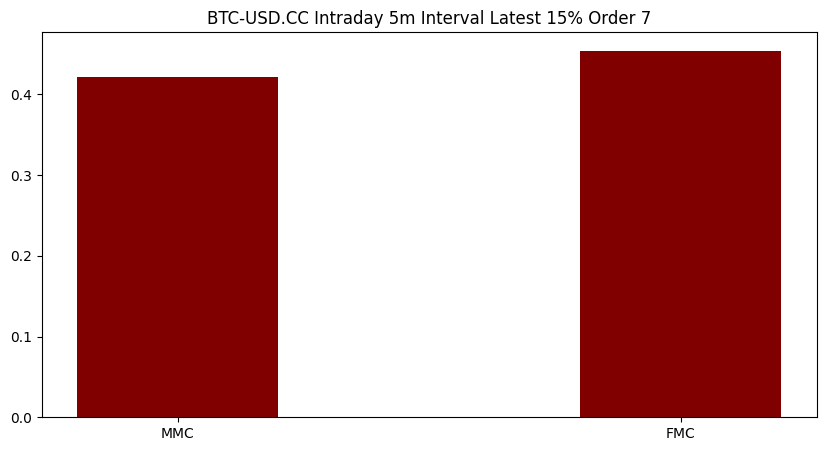

In [96]:
def create_bar_graph(data, title, types):
    plt.figure(figsize=(10, 5))

    # creating the bar plot
    plt.bar(types, data, color='maroon',
            width=0.4)

    plt.title(title)
    plt.show()
[m.__name__ for m in methods if m != MTD]

create_bar_graph(results_testing, f"{symbol} Intraday {interval} Interval Latest 15% Order {order}", [m.__name__ for m in methods if m != MTD])

In [37]:
[m.__name__ for m in methods]

['MMC', 'FMC', 'HMC']

## Choose model

In [39]:
mmc.predict([x_tr[-1]])

[0]